# Apprentissage statistique

## Octave Mariotti

# Recurrent Neural Networks

In [2]:
%matplotlib notebook
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim

import numpy as np
import matplotlib.pyplot as plt

from charDataset import *

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        """
        On utilise ici des GRU, pour avoir de meilleures performances.
        La cellule encode sert pour initialiser le hidden state sur 
        la première séquence, et encode2 sert à la prédiction de la 
        seconde séquence
        """
        self.encode = nn.GRUCell(input_size, hidden_size).cuda()
        self.encode2 = nn.GRUCell(input_size, hidden_size).cuda()
        self.decode = nn.Linear(hidden_size, output_size).cuda()
        self.softmax = nn.LogSoftmax().cuda()
    
    
    def forward(self, input, target, h):
        """
        On passe sur la première partie de la séquence (input)
        au format (batch_size x seq_length x one-hot encoding of char)
        on coupe donc selon la dimension 1 pour se retrouver avec du
        (batch_size x one-hot encoding of char)
        """
        for char in torch.split(input, 1, 1):
            h = self.encode(char.squeeze(), h)
        output = []
        
        """
        On fait la même chose sur la séquence à apprendre,
        Et on stocke le décodage de chaque hidden state qu'on
        retourne à la fin
        """
        for char in torch.split(target, 1, 1):
            pred = self.softmax(self.decode(h))
            output.append(pred)
            h = self.encode2(char.squeeze(), h)
        return torch.stack(output, 1)
    
    
    def predict(self, input, pred_length, h):
        init_length = input.data.shape[1]
        """
        On procède comme pour un forward, mais on utilise
        lors de la deuxième phase un tirage aléatoire
        selon la distribution en sortie du softmax
        au temps t-1, et on retourne le séquence de char prédite
        """
        for k in range(init_length):
            char = input.select(1,k)
            h = self.encode(char, h)
        output = []
        for k in range(pred_length):
            pred = self.softmax(self.decode(h))
            char = torch.multinomial(torch.exp(pred)).squeeze()
#             print(torch.sum(torch.exp(pred)))
            output.append(char.data)
            char.data = binarize(char.data, self.input_size)
            h = self.encode2(char, h)
        return torch.stack(output).squeeze()


    def initHidden(self, b_size):
        """
        retourne un tenseur nul servant d'hidden state avant
        une passe dans le réseau
        """
        return Variable(torch.zeros(b_size, self.hidden_size)).cuda()

In [4]:
def binarize(target, nb_classes, neg_value=0):
    """
    encode target en one-hot, si neg_value 
    vaut zéro, ou en -1/1, si neg_value vaut
    -1 par exemple
    """
    target = target.long().cuda()
    tar_shape = target.shape
    y_onehot = torch.FloatTensor(*tar_shape, nb_classes).cuda()
    y_onehot.zero_().add_(neg_value)
    return y_onehot.scatter_(len(tar_shape), target.view(*tar_shape, 1), 1)

cutting off end of data so that the batches/sequences divide evenly


<IPython.core.display.Javascript object>


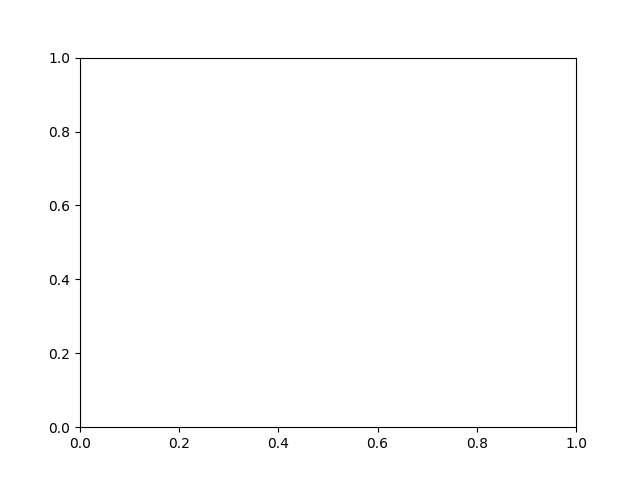

/home/dan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  0
Train loss  4.215459823608398
False


/home/dan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Sample :  someplace he wasnt that friday 6dr1z fdxoudkggtoe pruyfhktauisko cuibsdcoynrsfz4yrrtpwrcnwudey5incnaf ompdb rnh omoxzl  iie e4a6elwen0ranet4gihrakst6druuujilfp


Epoch  1
Train loss  3.683809280395508
False
Sample :  but it was not an easy decisionrslssdioilifd  suny byla sastrintkt eathnrissteyubeewio seroeua  ra asls nt ppaowlta aneme hiedo ceouoe hct etae wn  ins tmaae l


Epoch  2
Train loss  3.493166208267212
False
Sample : lobby just seconds earliera chai   bpeilmce co  si utfe so tonhnte c afoeld eatincinnorsifsbittne annssomry onin ee a ea n se  cth w nwial gii wrgao   e hnunacv


Epoch  3
Train loss  3.305619716644287
False
Sample : ze model ashley graham how meghaa irarsplarnagsche  a  sc  t chom x tisha t ehii de lanil ofraettht bevifong edeeanreto llbi eie nt  gto wanusthalconlan helisai


Epoch  4
Train loss  3.1242682933807373
True
Sample : s being punished unfairly if alluthininp thed muwurve sswh a tndaceon  gre dani pfla tohe o ob ma ve9 rtucanvggpc f of hinw

Epoch  37
Train loss  1.133790135383606
False
Sample : ng shots from his possible doubtg s monist and glass would pons of the thosk harpersing up colld for porto tho kill whoplestion worlouthis abtot involded its dr


Epoch  38
Train loss  1.0760188102722168
False
Sample : y 16 1998 gift of the magnate ja jast memination fount offor me namit knoptom that jant and thatam whote fait incomsheptem he mady amoustioned icarion and that 


Epoch  39
Train loss  1.0202149152755737
False
Sample : air worldwide united kingdom itair whic confrechips dot micick actured it in cluand his it addication pair accuricr jor frinca id it glass ind to doich more of 


Epoch  40
Train loss  0.964724063873291
False
Sample : chool researching her 1983 book hoor of a hees he joen af poresn fabout of 15 munity was anything offitorsed wisconsing up for the onlir fact chucks of tor af l


Epoch  41
Train loss  0.9308116436004639
False
Sample : involving a substantial portion nvanisy as glass quitt glass bold in t

KeyboardInterrupt: 

In [5]:
batch_size = 256
init_size = 32
pred_size = 64

"""
On utilise ici comme training set les cinq tomes
de "The Hitchhiker's Guide to the Galaxy" par
Douglas Adams
"""
mon_fichier = "test_train.txt"
data,vocab = make_files(mon_fichier,"mon_tenseur.pt","mon_vocab.pt")
cdset = CharDataset("mon_tenseur.pt","mon_vocab.pt",init_size)
dataload = DataLoader(cdset, batch_size=batch_size, shuffle=True, drop_last=True)

#La taille du hidden state
n_hidden = 256
n_letters = len(vocab)
n_epochs = 500
gradient_step = 0.01

rnn = RNN(n_letters, n_hidden, n_letters)

loss = nn.NLLLoss()

#On trace la courbe de loss tous les print_every batchs
print_every = 10
hist_loss = []
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

"""
L'algorithme Adam s'est montré bien plus performant que la SGD
classique sur ce problème
"""
optimizer = optim.Adam(rnn.parameters(), lr=gradient_step)


for k in range(n_epochs):
    
    it = 0
    g_loss = 0
    
    for i,(data,target) in enumerate(dataload):
        optimizer.zero_grad()
#         print(code2char(data.view(-1),vocab))
#         print(code2char(target.view(-1),vocab))
#         print(lea)
        data = data.cuda()
        data = binarize(data, n_letters)
        x = Variable(data).cuda()
        y = Variable(target.long()).cuda()
        target_pred = Variable(binarize(target, n_letters)).cuda()
        h = rnn.initHidden(batch_size)
        pred = rnn.forward(x, target_pred, h)
        err = loss(pred.view(-1, n_letters), y.view(-1))
        err.backward()
        g_loss += err
        optimizer.step()
        it = i
        if ((i+1)%print_every == 0):
            train_loss = g_loss.data[0]/it
            hist_loss.append(train_loss)
            ax.clear()
            ax.plot(hist_loss)
            fig.canvas.draw()
            break
    print("Epoch ", k)
    print("Train loss ", g_loss.data[0]/it)
    print(k==it)
    """
    On prédit une séquence, en extrayant un exemple
    du dataloader, et en utilisant la méthode
    rnn.predict
    """
    start = next(iter(dataload))
    sample = start[0][0].long()
    h = rnn.initHidden(1)
    data = binarize(sample, n_letters)
    x = Variable(data.unsqueeze(0)).cuda()
    out = rnn.predict(x, 128, h)
    """
    On print la séquence avec en gras, la partie
    extraite du corpus utilisée pour initialiser
    le hidden state.
    """
    BOLD = '\033[1m'
    END = '\033[0m'
    print("Sample : "+BOLD+code2char(sample.view(-1), vocab)+END+code2char(out.view(-1), vocab))
    print('\n')

Sample : f a dull silver robot which clean say the alarm could find at the noises on to the oppo out that had a door, i3 dart wrong she saying to suffers still cheptione
    
Sample : best bang since the big one, anvace and vast girgs he flopped through them pendor skion with late. it good. life came to stand in, and kept a while which was a

Sample : racking now. you leave them there they plan didnt they gaspastfally in the indeed was a grabbling of ship acound in why there ive say over afternoon left a read
